In [45]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Let's read in the data!

In [46]:
def parse_document_content(filename):
    data = []
    
    with open(filename, "r") as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            
            doc_class = line[0]
            doc_content = line[2:-2]
            data.append([doc_class, doc_content])
            
    return data

In [47]:
data = parse_document_content("data/file.txt")
df = pd.DataFrame(data, columns=["class", "content"])
df.head(5)


class                                            content
0     1  champion products ch approves stock split cham...
1     2  computer terminal systems cpml completes sale ...
2     1  cobanco inc cbco year net shr cts vs dlrs net ...
3     1  am international inc am nd qtr jan oper shr lo...
4     1  brown forman inc bfd th qtr net shr one dlr vs...

In [48]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

def plot_label_frequency(df, normalize=False):
    df_plot = df['class'].value_counts().reset_index(name='count')
    #print(df_plot)
    
    fig = plt.figure(figsize = (10, 5))
    document_types = df_plot["index"]
    if normalize:
        document_frequencies = df_plot["count"] / df_plot["count"].sum()
        document_frequencies = document_frequencies.round(2)
    else:
        document_frequencies = df_plot["count"]
    plt.bar(document_types, document_frequencies, color='blue', width=0.5)
    
    plt.xlabel('Document Class')
    plt.ylabel("Document Frequency (Count)")
    plt.title("Class Frequency distribution")
    addlabels(document_types, document_frequencies)
    plt.show()

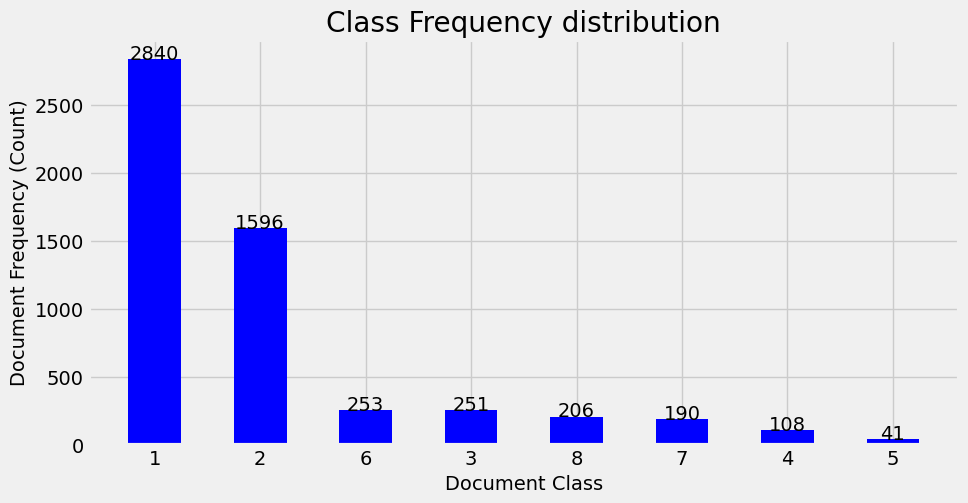

In [49]:
plot_label_frequency(df)

We have a massive class imbalance in the dataset! Class 1 and class 2 are overrepresented in the dataset. Let's find out next the percentage of the dataset each class represents 

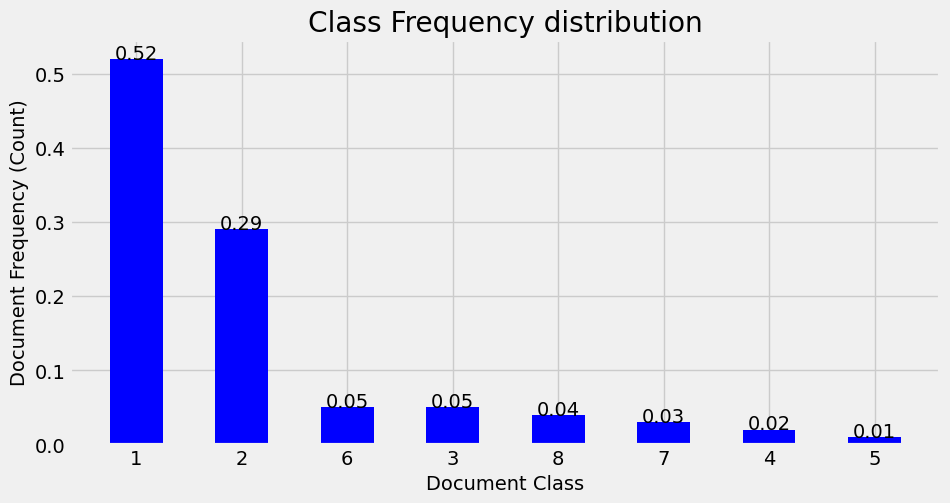

In [50]:
plot_label_frequency(df, True)

Document type 1 and 2 represent 52% and ~30% of the dataset respectively! 
Documet types 3 through 5 each only represent <= 5% of the total dataset. The class imbalance will pose a challenge to any classification model. 

# Document Content Analysis

let's take a quick peak into the content of these documents. We will use word clouds to visualize the top most ocuring words, by frequency, for each document class

In [51]:
!pip3 install wordcloud
import wordcloud

     |████████████████████████████████| 158 kB 3.4 MB/s eta 0:00:01
You should consider upgrading via the '/Users/stephone_christian/Desktop/document_class/setup/bin/python3 -m pip install --upgrade pip' command.


In [52]:
def get_class_text(df, dataset_class):
    filter_ = df['class'] == dataset_class
    #print(df[filter].head(10))
    text = " ".join(df[filter_]['content'])
    return text
    
    
def create_word_cloud(df):
    ROW = 4
    COL = 2
    #dataset_class = str(dataset_class)

    fig, ax = plt.subplots(ROW, COL, figsize=(50,50))
    fig.suptitle('wordcloud for each document class', fontsize=50)
    
    
    count = 1
    
    for row in range(ROW):
        for col in range(COL):
            
            dataset_class = str(count)
            text = get_class_text(df, dataset_class)
            word_cloud = wordcloud.WordCloud(random_state=1,background_color='white', colormap='Set2', collocations=False, stopwords = wordcloud.STOPWORDS).generate(text)
            count +=1
            ax[row, col].imshow(word_cloud, interpolation='bilinear')
            ax[row, col].set_title(f'Document {dataset_class} wordcloud', fontsize=25)
    

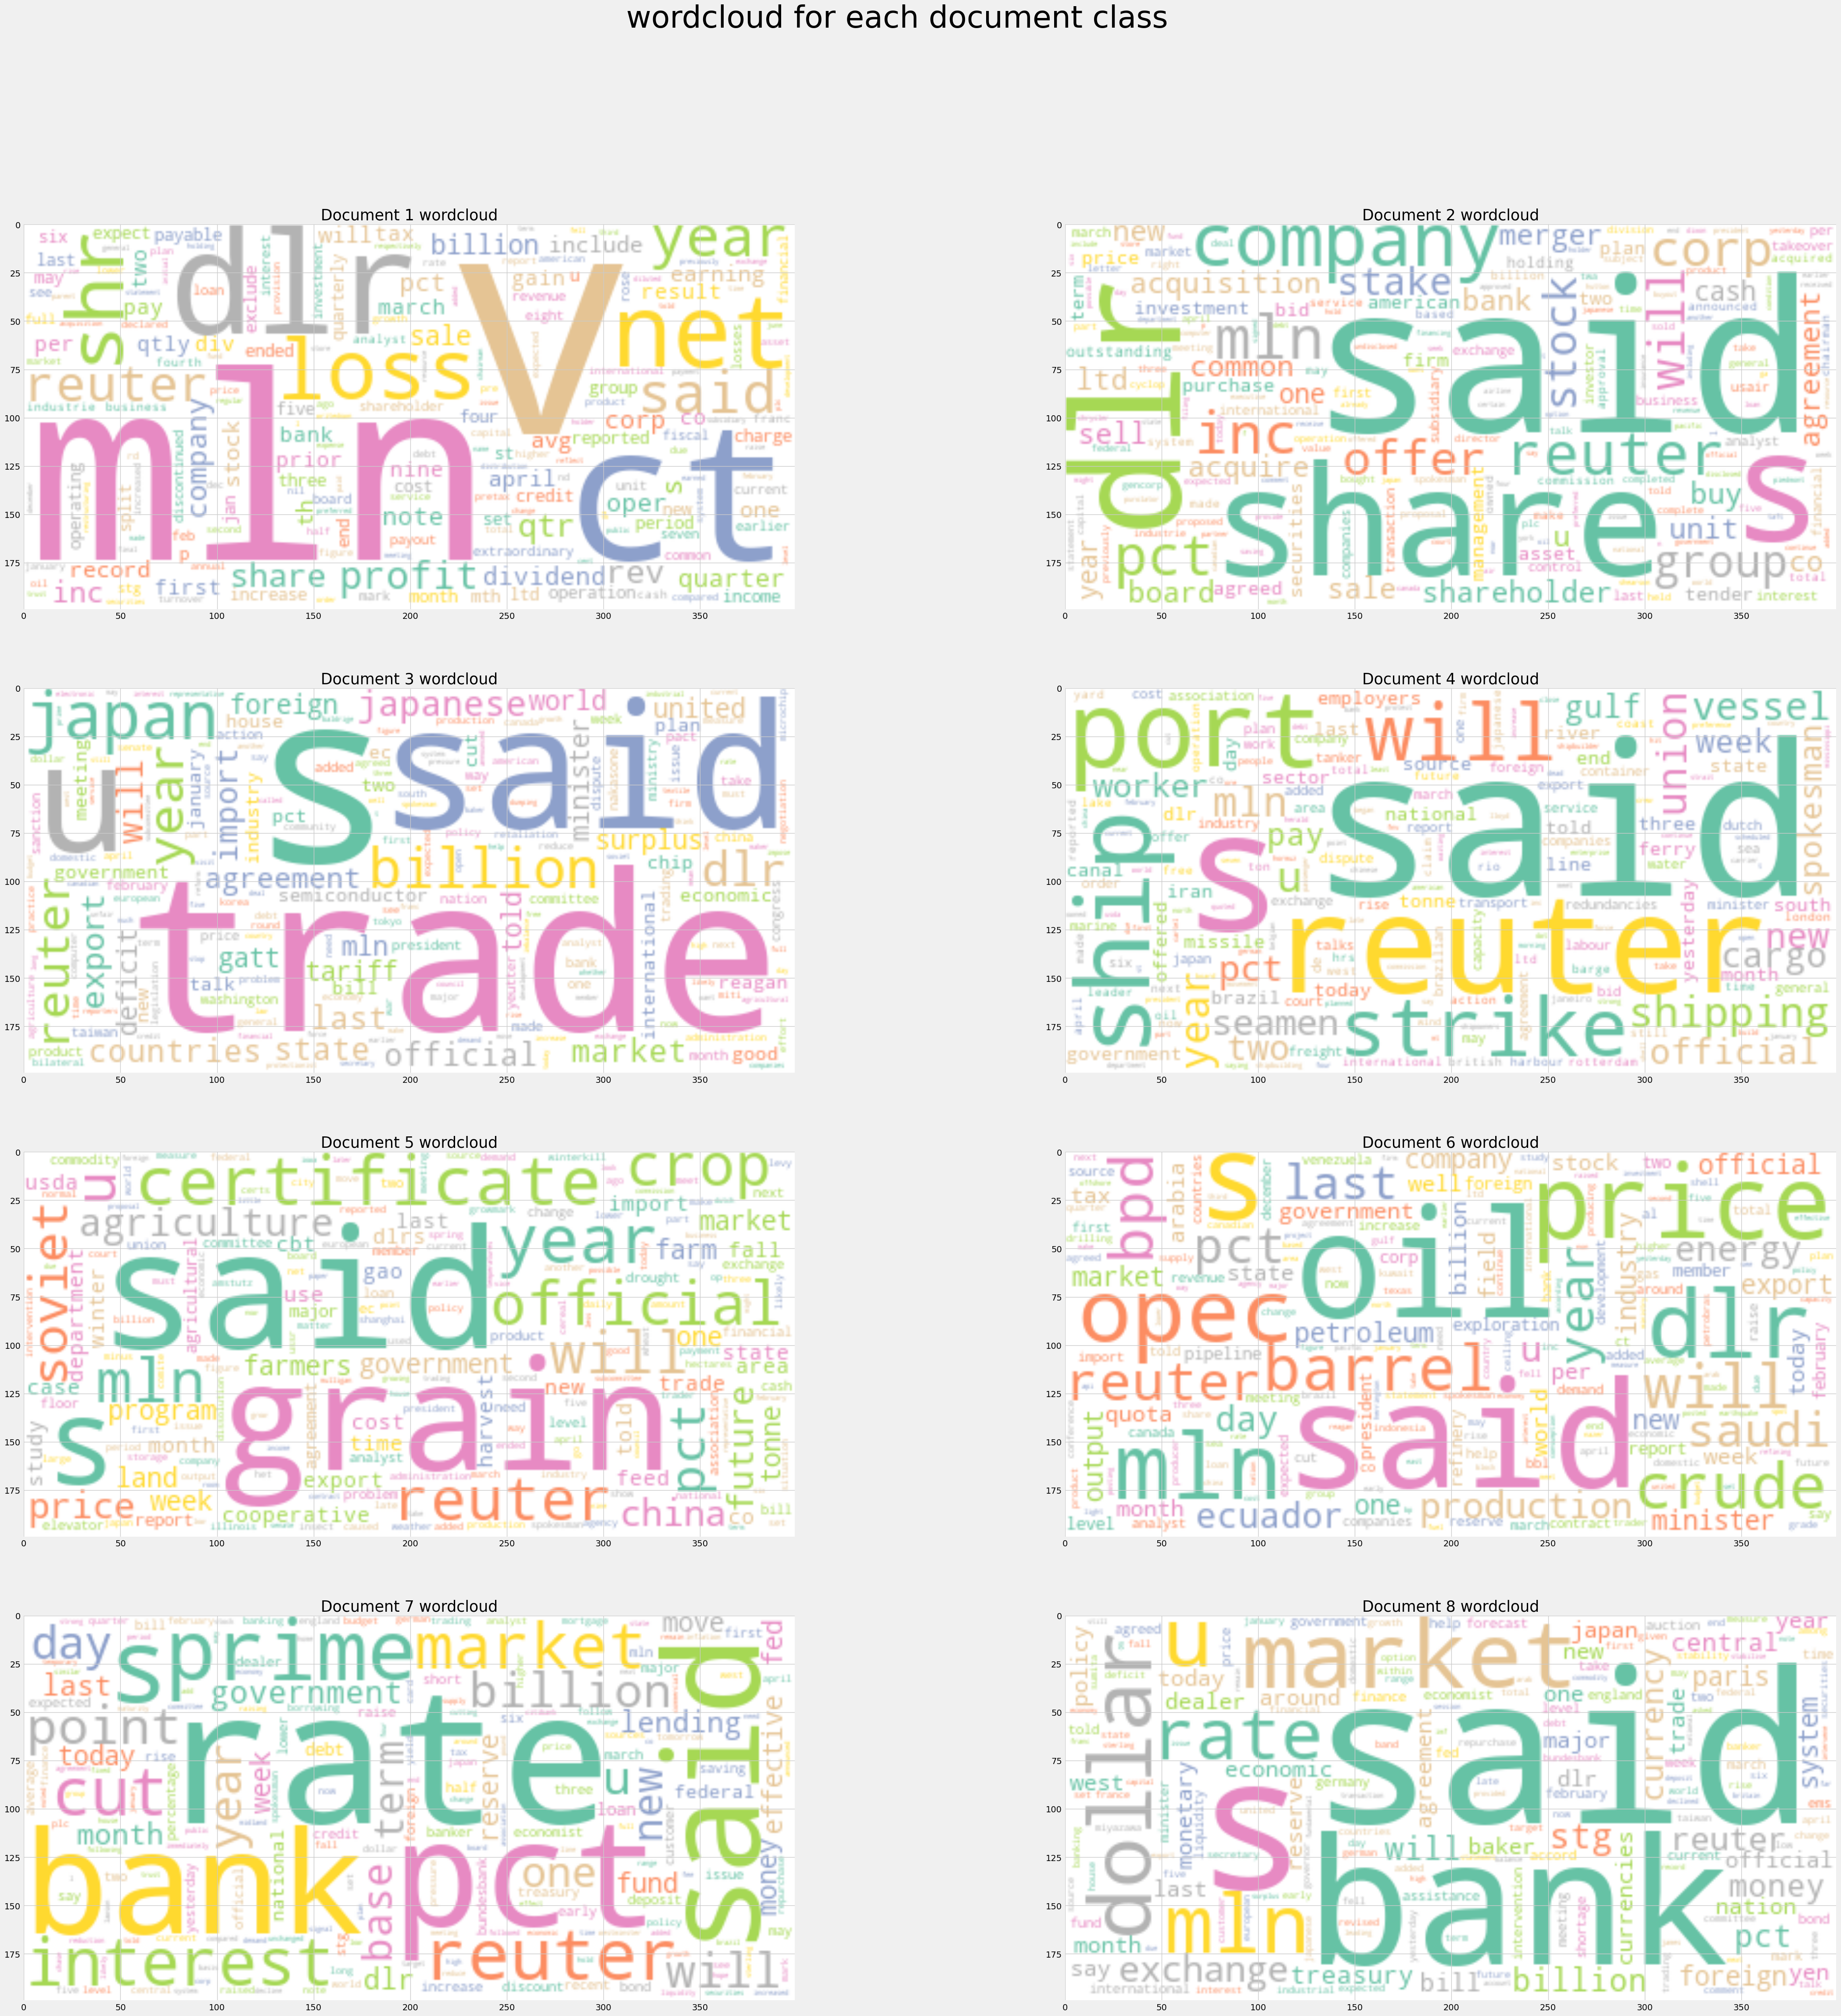

In [53]:
create_word_cloud(df)

The wordclouds for each document reveal a few things
"Said" appears in high frequency across most document classes. The future 
classifier may have issues with this token. I may consider stripping this token from all documents

* upon close inspection, one can tell (roughly) what each document class is about. 
* Document class 1 seems most related to stocks, trades, and finance
* Document class 2 seems most related to corporate politics
* Document class 3 import / export relations between countries
* Document class 4 naval / shipping / boats 
* Document class 5 agricultural economics and politics
* Document class 6 oil and energy production
* Document class 7 global and national dept
* DOcument class 8 forex (currency exchange, etc)


We plan on employing a fine-tuned Bert model to classify our documents. When reading in the vectorized text, we require that each
training example be the same length. We must also make sure that the input length  is less than or equal 512, as this is the largest
input size that Bert can handle!

Additionally, we have a computational constraint. Truncating and padding to 512 is all fine and dandy, but it's best if we take a look at the distribution of length
in the dataset :)

In [54]:
from collections import defaultdict
def frequency_count(df):

    string_lengths = df['content'].apply(lambda x: len(x.split(" "))).to_list()

    d = defaultdict(lambda: 0)
    for length in string_lengths:
        d[length] += 1
    return d

def plot_frequency_count(d):

    data = [[k,v] for k,v in d.items()]
    data.sort(key=lambda x: x[0])
    x = [x[0] for x in data]
    y = [x[1] for x in data]

    fig = plt.figure(figsize = (8, 5))

    plt.bar(x,y, color='green', width=0.3)
    plt.xlabel("length of training example")
    plt.ylabel("frequency (count)")
    plt.title("distribution of training data length")

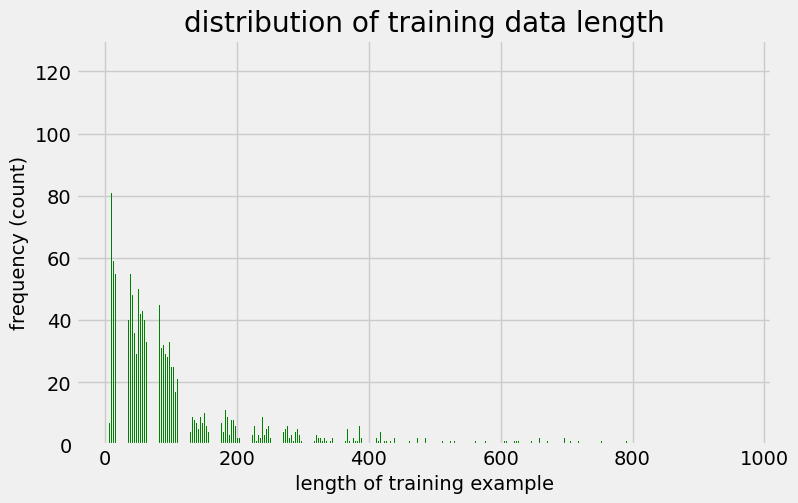

In [55]:
d = frequency_count(df)
plot_frequency_count(d)

looks like there are articles that are as long as ~1000 words! Let's truncate to 256 for a first iteration, then experiment with 128 and 512. We'll consider the length of the article a hyperparameter
of our algorithm